In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load auxiliary data

In [112]:
coe_prices = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-coe-prices.csv")
existing_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv")
future_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-planned-stations.csv")
schools = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-primary-schools.csv")
malls = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-shopping-malls.csv")
stock = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-stock-prices.csv")

### Load Preprocessed Data

In [113]:
dataset = pd.read_csv("data/train_preprocessed.csv")

### Inspect COE Price Trend

In [114]:
coe_prices.head()

,year,category,month,bidding,price,quota,bids
0,2023,a,july,2,95202,581,728
1,2023,a,july,1,97000,588,756
2,2023,a,june,2,96206,586,751
3,2023,a,june,1,98001,581,881
4,2023,a,may,2,92000,596,936


In [115]:
months = {
    "january": 1,
    "february": 2,
    "march": 3,
    "april": 4,
    "may": 5,
    "june": 6,
    "july": 7,
    "august": 8,
    "september": 9,
    "october": 10,
    "november": 11,
    "december": 12
}

coe_prices['month'] = coe_prices['month'].apply(lambda x: months[x])
coe_prices["date"] = pd.to_datetime(coe_prices[["year", "month"]].assign(DAY=1))
coe_prices["date"] = np.where(coe_prices["bidding"]==2, coe_prices['date']+pd.DateOffset(days=15), coe_prices['date'])
coe_prices["date"] = coe_prices["date"].dt.strftime('%Y-%m-%d')
coe_prices.dtypes


year         int64
category    object
month        int64
bidding      int64
price        int64
quota        int64
bids         int64
date        object
dtype: object

In [119]:
coe_prices.sort_values(by='date', ascending=True)
coe_prices_a = coe_prices.loc[coe_prices['category']=='a']
coe_prices_b = coe_prices.loc[coe_prices['category']=='b']
coe_prices_c = coe_prices.loc[coe_prices['category']=='c']
coe_prices_e = coe_prices.loc[coe_prices['category']=='e']
coe_prices['category'].unique()

array(['a', 'b', 'c', 'e'], dtype=object)

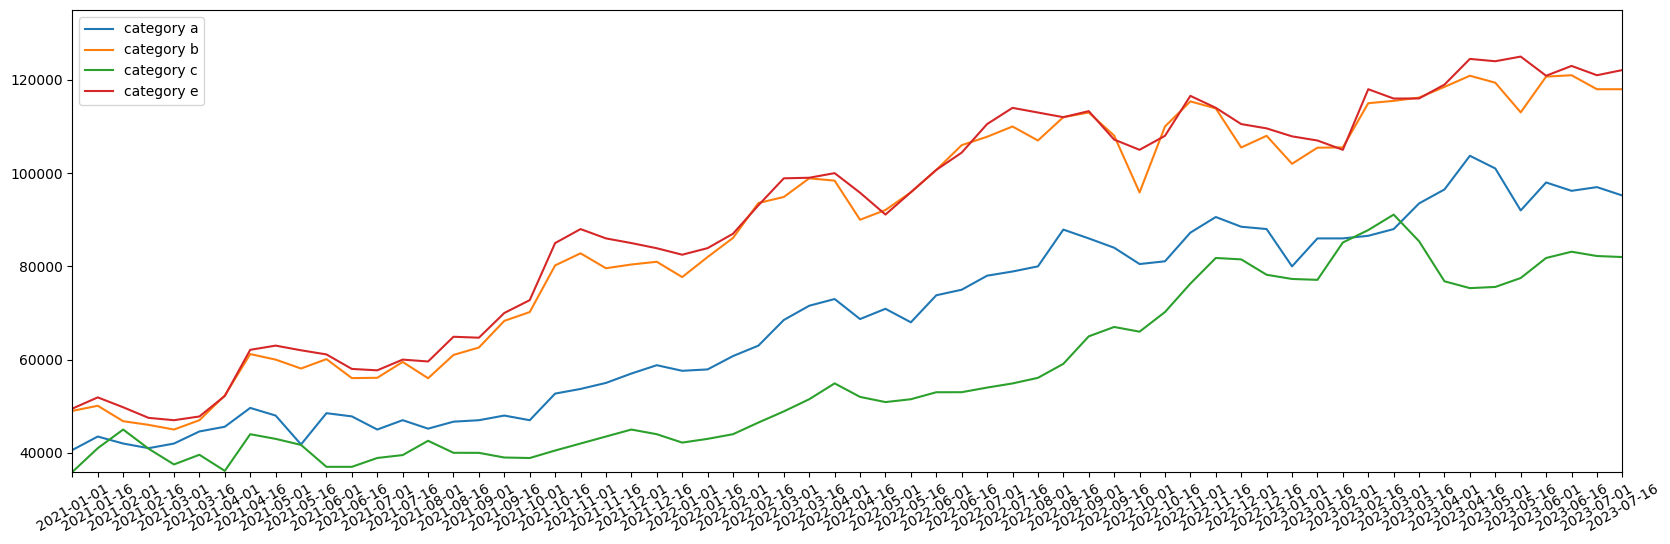

In [123]:
plt.figure(figsize=(20, 6))
plt.plot(coe_prices_a["date"], coe_prices_a["price"])
plt.plot(coe_prices_b["date"], coe_prices_b["price"])
plt.plot(coe_prices_c["date"], coe_prices_c["price"])
plt.plot(coe_prices_e["date"], coe_prices_e["price"])
plt.xticks(coe_prices_a["date"], rotation=30)
plt.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), min(coe_prices["price"]), max(coe_prices["price"])+10000])
plt.legend(['category a', 'category b', 'category c', 'category e'])

### Plot Locations of Places of Interest

In [147]:
existing_mrt


,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418
...,...,...,...,...,...
157,TE17,Outram Park,2022,1.280242,103.840052
158,TE18,Maxwell,2022,1.280533,103.843884
159,TE19,Shenton Way,2022,1.277717,103.850368
160,TE20,Marina Bay,2022,1.276311,103.854605


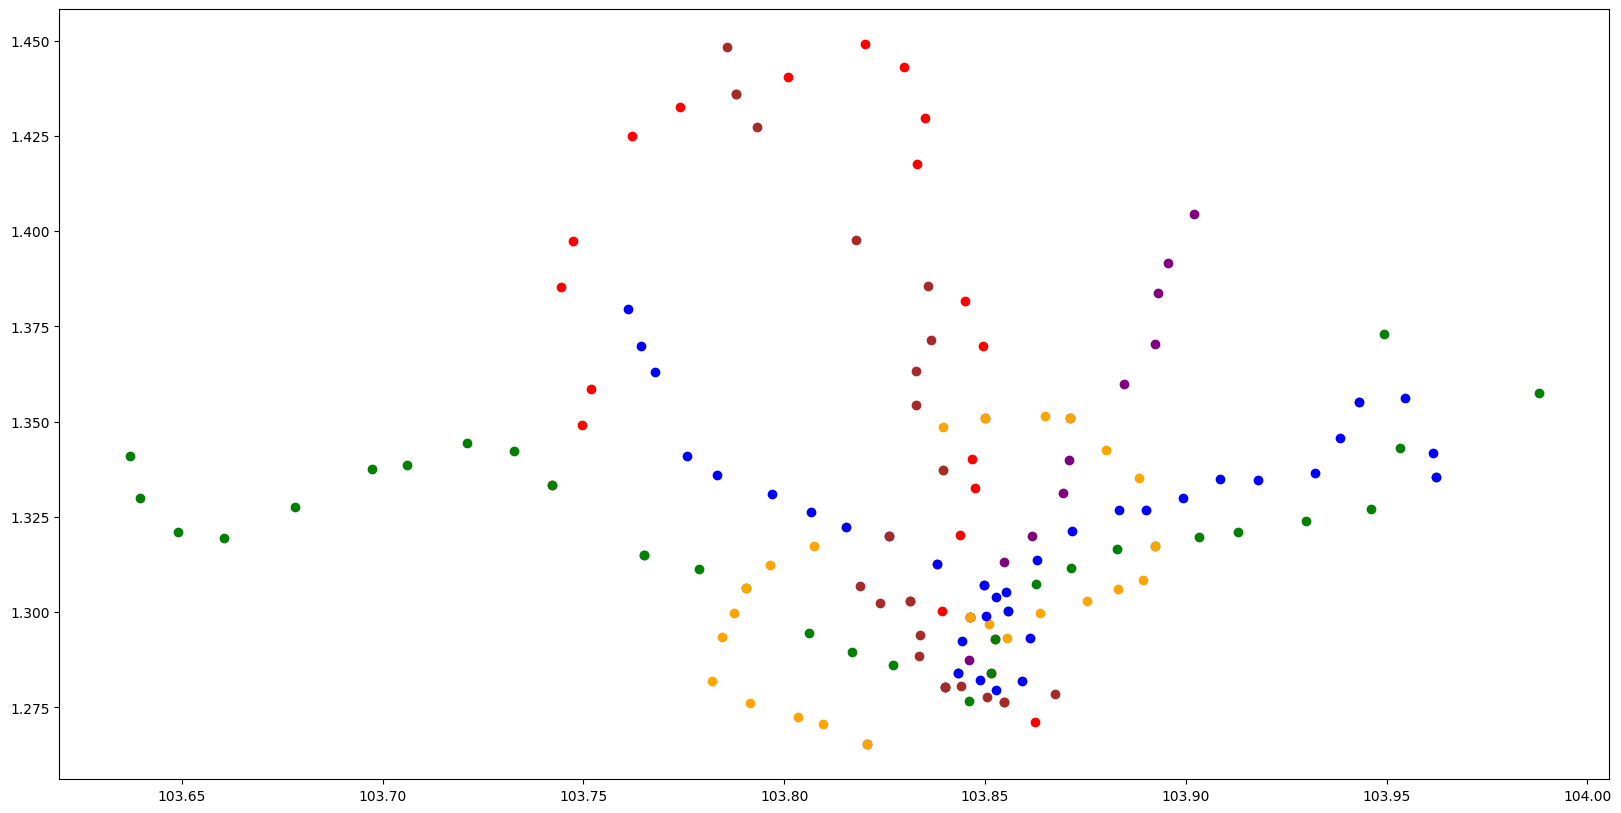

In [146]:
plt.figure(figsize=(20,10))
mrt_colours = {"NS": "red", "EW": "green", "CG": "green", "NE": "purple", "CC": "orange", "DT": "blue", "TE": "brown", "CE": "orange"}
for i in range(len(existing_mrt)):
    code = existing_mrt.loc[i, "code"][:2]
    color = mrt_colours[code]
    plt.scatter(x=existing_mrt.loc[i, "longitude"], y=existing_mrt.loc[i, "latitude"], c=color)
    

In [135]:
future_mrt.head()


,code,name,opening_year,latitude,longitude
0,NaN,Brickland,2030,1.369700,103.747900
1,NaN,Sungei Kadut,2030,1.413300,103.748800
2,NaN,Punggol Coast,2024,1.415280,103.911110
3,NaN,Bukit Brown,TBA,1.333639,103.830075
4,NaN,Keppel,2026,1.270100,103.831000


In [136]:
malls.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


In [137]:
schools.head()

,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165
